In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import tensorflow as tf
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
# Wczytaj:
# - train.csv
# - model.h5
# - models (folder)
# - aux_models (folder)

In [ ]:
main_model = tf.keras.models.load_model('model.h5')

In [ ]:
import os
import pandas as pd
from tensorflow.keras.models import load_model

# Ścieżka do folderu z modelami
folder_path = "models"

# Lista do przechowywania informacji o modelach
models_data = []

# Iteracja przez pliki w folderze
for filename in os.listdir(folder_path):
    if filename.endswith(".h5"):  # Sprawdzenie rozszerzenia pliku
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)  # Załadowanie modelu
        models_data.append({"Model Name": filename, "Model Object": model})
        print(f"Załadowano model: {filename}")

# Tworzenie ramki danych
models_df = pd.DataFrame(models_data)

print(f"Liczba załadowanych modeli: {len(models_df)}")
print(models_df)

Załadowano model: DD_model_T10.h5


Załadowano model: AD_model_CW_0.3.h5


Załadowano model: AD_model_PGD_0.3.h5


Załadowano model: DD_model_T5.h5


Załadowano model: AD_model_CW_0.2.h5
Załadowano model: AD_model_PGD_0.4.h5


Załadowano model: DD_model_T50.h5


Załadowano model: AD_model_PGD_0.2.h5


Załadowano model: DD_model_T20.h5


Załadowano model: DD_model_T40.h5


Załadowano model: AD_model_CW_0.4.h5


Załadowano model: DD_model_T30.h5
Liczba załadowanych modeli: 12
             Model Name                                Model Object
0       DD_model_T10.h5  <Sequential name=sequential_2, built=True>
1    AD_model_CW_0.3.h5  <Sequential name=sequential_1, built=True>
2   AD_model_PGD_0.3.h5  <Sequential name=sequential_4, built=True>
3        DD_model_T5.h5  <Sequential name=sequential_1, built=True>
4    AD_model_CW_0.2.h5    <Sequential name=sequential, built=True>
5   AD_model_PGD_0.4.h5  <Sequential name=sequential_5, built=True>
6       DD_model_T50.h5  <Sequential name=sequential_6, built=True>
7   AD_model_PGD_0.2.h5  <Sequential name=sequential_3, built=True>
8       DD_model_T20.h5  <Sequential name=sequential_3, built=True>
9       DD_model_T40.h5  <Sequential name=sequential_5, built=True>
10   AD_model_CW_0.4.h5  <Sequential name=sequential_2, built=True>
11      DD_model_T30.h5  <Sequential name=sequential_4, built=True>


In [ ]:
import os
import pandas as pd
from tensorflow.keras.models import load_model

# Ścieżka do folderu z modelami
folder_path = "aux_models"

# Lista do przechowywania informacji o modelach
models_data = []

# Iteracja przez pliki w folderze
for filename in os.listdir(folder_path):
    if filename.endswith(".h5"):  # Sprawdzenie rozszerzenia pliku
        model_path = os.path.join(folder_path, filename)
        model = load_model(model_path)  # Załadowanie modelu
        models_data.append({"Model Name": filename, "Model Object": model})
        print(f"Załadowano model: {filename}")

# Tworzenie ramki danych
aux_models_df = pd.DataFrame(models_data)

print(f"Liczba załadowanych modeli: {len(aux_models_df)}")
print(aux_models_df)

Załadowano model: ADM_model_extended_split_0.2.h5


Załadowano model: ADM_model_extended_split_1.h5
Załadowano model: ADM_model_extended_split_0.3.h5


Załadowano model: ADM_model_extended_split_0.5.h5


Załadowano model: ADM_model_extended_split_0.4.h5
Liczba załadowanych modeli: 5
                        Model Name                                Model Object
0  ADM_model_extended_split_0.2.h5  <Sequential name=sequential_3, built=True>
1    ADM_model_extended_split_1.h5  <Sequential name=sequential_3, built=True>
2  ADM_model_extended_split_0.3.h5  <Sequential name=sequential_3, built=True>
3  ADM_model_extended_split_0.5.h5  <Sequential name=sequential_3, built=True>
4  ADM_model_extended_split_0.4.h5  <Sequential name=sequential_3, built=True>


## Data

In [ ]:
data = pd.read_csv('train.csv')

X = data.iloc[:,1:]
Y = data.iloc[:,0]

X_reshaped = X.values.reshape(-1, 28, 28, 1)
X_reshaped = X_reshaped.astype("float32")/255

images = X_reshaped[0:100]
labels = Y[0:100]
labels_encoded = to_categorical(labels, num_classes=10)

## Attacks

In [ ]:
def fgsm_attack(model, images, labels, c):
    """
    Wykonuje atak FGSM na zadanym modelu.

    Args:
        model: Wytrenowany model.
        images: Obrazy wejściowe (tensor).
        labels: Prawdziwe etykiety klas obrazów (tensor).
        epsilon: Wartość epsilon kontrolująca intensywność ataku.

    Returns:
        Tensor z wygenerowanymi obrazami adversarialnymi.
    """
    # Tworzymy tensor z danymi wejściowymi, aby obliczyć gradienty
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        tape.watch(images)
        # Przewidywanie wyników dla obrazów
        predictions = model(images)
        # Obliczamy stratę (najczęściej używana jest entropia krzyżowa)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

    # Obliczamy gradienty straty względem wejścia (obrazów)
    gradients = tape.gradient(loss, images)
    # Znak gradientów
    signed_grad = tf.sign(gradients)
    # Dodajemy perturbację o skali epsilon, tworząc obraz adversarialny
    adversarial_images = images + c * signed_grad
    # Ograniczamy wartości pikseli, aby pozostały w zakresie [0, 1]
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)

    return adversarial_images

In [ ]:
def pgd_attack(model, images, labels, c, epsilon, num_iterations, norm_type='linf', threshold=None):
    """
    Przeprowadza atak PGD z kontrolą normy perturbacji i możliwością wcześniejszego zakończenia.

    Parametry:
    - model: Model Keras lub TensorFlow
    - images: Obrazy wejściowe (batch)
    - labels: Etykiety one-hot dla obrazów
    - epsilon: Maksymalna wielkość perturbacji
    - alpha: Krok każdej iteracji
    - num_iterations: Maksymalna liczba iteracji
    - norm_type: Typ normy ('l0', 'l1', 'l2', 'linf')
    - threshold: Próg zmiany perturbacji dla wcześniejszego zakończenia (opcjonalny)

    Zwraca:
    - Adwersarialne obrazy
    """
    # Inicjalizujemy perturbacje jako kopię obrazów wejściowych
    perturbed_images = tf.identity(images)

    if len(labels.shape) == 1:
        labels= tf.convert_to_tensor([labels])

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_images)
            predictions = model(perturbed_images)
            loss = tf.keras.losses.categorical_crossentropy(labels, predictions)

        # Obliczamy gradient
        gradient = tape.gradient(loss, perturbed_images)

        # Generowanie perturbacji na podstawie wybranej normy
        if norm_type == 'Linf':
            perturbation = c * tf.sign(gradient)
        elif norm_type == 'L2':
            # Ręczne obliczenie normy L2
            norm = tf.sqrt(tf.reduce_sum(tf.square(gradient), axis=(1, 2, 3), keepdims=True))
            perturbation = c * gradient / (norm + 1e-10)
        else:
            raise ValueError("Nieobsługiwana norma. Użyj 'l2' lub 'linf'.")

        # Aktualizacja obrazów adwersarialnych
        new_perturbed_images = perturbed_images + perturbation
        new_perturbed_images = tf.clip_by_value(new_perturbed_images, images - epsilon, images + epsilon)  # projekcja
        new_perturbed_images = tf.clip_by_value(new_perturbed_images, 0, 1)  # ograniczenie do zakresu [0,1]

        # Sprawdzenie progu zmiany perturbacji
        if threshold is not None:
            delta = tf.reduce_max(tf.abs(new_perturbed_images - perturbed_images))
            if delta < threshold:
                print(f"Zatrzymanie po {i + 1} iteracjach (zmiana < {threshold})")
                break

        perturbed_images = new_perturbed_images

    return perturbed_images


In [ ]:
import tensorflow as tf
import numpy as np
import statistics as stat

def cw_attack(model, images, labels, norm='L2', c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01):
    """
    Atak CW (Carlini & Wagner) z obsługą norm L2, Linf.
    Argumenty:
        model: Model Keras, który ma zostać zaatakowany.
        images: Obrazy wejściowe, skalowane do zakresu [0, 1].
        labels: Prawdziwe etykiety dla ataku nietargetowanego lub docelowe etykiety dla ataku targetowanego (zakodowane one-hot).
        norm: Typ normy dla perturbacji ('L2', 'Linf').
        c: Parametr regularyzacji kontrolujący wielkość perturbacji.
        kappa: Margines pewności ataku.
        max_iter: Maksymalna liczba kroków optymalizacji.
        learning_rate: Współczynnik uczenia dla optymalizatora.
    Zwraca:
        Zmodyfikowane obrazy z perturbacją (obrazy atakujące).
    """

    # Konwersja obrazów i etykiet na tensory
    original_images = tf.convert_to_tensor(images, dtype=tf.float32)
    true_labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    # Inicjalizacja perturbacji w przestrzeni tanh
    w = tf.Variable(tf.zeros_like(original_images), trainable=True, dtype=tf.float32)

    # Optymalizator
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Definicja funkcji f
    def f(x):
        logits = model(x)
        one_hot_labels = true_labels
        true_logits = tf.reduce_sum(one_hot_labels * logits, axis=1)
        other_logits = tf.reduce_max((1 - one_hot_labels) * logits - one_hot_labels * 1e4, axis=1)
        return tf.maximum(true_logits - other_logits, -kappa)

    # Definicja funkcji normy perturbacji
    def perturbation_norm(perturbed_images, original_images, norm):
        if norm == 'L2':
            return tf.reduce_sum(tf.square(perturbed_images - original_images), axis=[1, 2, 3])
        elif norm == 'Linf':
            return tf.reduce_max(tf.abs(perturbed_images - original_images), axis=[1, 2, 3])
        else:
            raise ValueError(f"Nieobsługiwana norma: {norm}")

    # Przeprowadzenie optymalizacji
    prev_loss = 1e10
    for step in range(max_iter):
        with tf.GradientTape() as tape:
            # Przekształcenie w do przestrzeni obrazów za pomocą tanh
            perturbed_images = 0.5 * (tf.tanh(w) + 1)

            # Obliczenie składowych funkcji straty
            norm_loss = perturbation_norm(perturbed_images, original_images, norm)
            f_loss = c * f(perturbed_images)
            total_loss = tf.reduce_sum(norm_loss + f_loss)

        # Obliczenie gradientów i aktualizacja parametrów
        gradients = tape.gradient(total_loss, [w])
        optimizer.apply_gradients(zip(gradients, [w]))

        # Sprawdzenie warunku wcześniejszego zatrzymania
        if step % (max_iter // 10) == 0:
            # print(f"Krok {step}/{max_iter}, Strata: {total_loss.numpy()}, norm_loss: {stat.mean(norm_loss.numpy())}, f_loss: {stat.mean(f_loss.numpy())}")
            if total_loss.numpy() > prev_loss:
                print("Atak zatrzymany z powodu zbieżności.")
                break
            prev_loss = total_loss.numpy()

    # Mapowanie końcowego w do przestrzeni obrazów
    attack_images = 0.5 * (tf.tanh(w) + 1)
    return attack_images


## Rest of code

In [ ]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import numpy as np

# Parametry dla poszczególnych ataków
fgsm_params = {'c_values': [0.05], 'norm_type': 'Linf'}
cw_params = {'c_values': [0.3], 'norm_type': 'L2'}
pgd_params = {'c_values': [0.1], 'norm_type': 'L2'}

# Funkcja do obliczania metryk na danych oryginalnych
def compute_metrics_on_original(models_df, original_images, original_labels):
    original_results = []

    for _, row in models_df.iterrows():
        model_name = row['Model Name']
        model = row['Model Object']

        # Klasyfikacja obrazów oryginalnych
        predictions = np.argmax(model.predict(original_images), axis=1)

        # Obliczanie metryk
        accuracy = accuracy_score(original_labels, predictions)
        precision = precision_score(original_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(original_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(original_labels, predictions, average='weighted', zero_division=0)

        # Zapis wyników
        original_results.append({
            'Model Name': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    return pd.DataFrame(original_results)

# Funkcja pomocnicza do obliczania metryk dla danych zakłóconych (adwersarialnych)
def compute_metrics_on_adversarial(main_model ,models_df, attack_type, attack_params, original_images, original_labels):
    adversarial_results = []

    for _, row in models_df.iterrows():
        model_name = row['Model Name']
        model = row['Model Object']

        # Generowanie danych adwersarialnych
        adversarial_images = []
        for c in attack_params['c_values']:
            if attack_type == 'FGSM':
                adversarial_images.extend(fgsm_attack(main_model, original_images, original_labels, c=c))
            elif attack_type == 'CW':
                adversarial_images.extend(cw_attack(main_model, original_images, to_categorical(original_labels, num_classes=10), c=c, norm=attack_params['norm_type'], max_iter=50))
            elif attack_type == 'PGD':
                adversarial_images.extend(pgd_attack(main_model, original_images, to_categorical(original_labels, num_classes=10), c=c, epsilon=0.01, num_iterations=50, norm_type=attack_params['norm_type']))

        adversarial_images = np.array(adversarial_images)

        # Klasyfikacja obrazów adwersarialnych
        predictions = np.argmax(model.predict(adversarial_images), axis=1)

        # Obliczanie metryk
        accuracy = accuracy_score(original_labels, predictions)
        precision = precision_score(original_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(original_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(original_labels, predictions, average='weighted', zero_division=0)

        # Zapis wyników
        adversarial_results.append({
            'Model Name': model_name,
            'Attack Type': attack_type,
            'Norm': attack_params['norm_type'],
            'c': attack_params['c_values'],
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    return pd.DataFrame(adversarial_results)

# Przygotowanie danych oryginalnych
images = X_reshaped[:1000]
labels = Y[:1000]

# Obliczanie metryk na oryginalnych danych
print("Rozpoczynam obliczenia dla danych oryginalnych...")
original_metrics = compute_metrics_on_original(models_df, images, labels)

# Obliczanie metryk dla danych zakłóconych (adwersarialnych)
print("Rozpoczynam obliczenia dla ataku FGSM...")
fgsm_adversarial_metrics = compute_metrics_on_adversarial(main_model, models_df, 'FGSM', fgsm_params, images, labels)

print("Rozpoczynam obliczenia dla ataku CW...")
cw_adversarial_metrics = compute_metrics_on_adversarial(main_model, models_df, 'CW', cw_params, images, labels)

print("Rozpoczynam obliczenia dla ataku PGD...")
pgd_adversarial_metrics = compute_metrics_on_adversarial(main_model, models_df, 'PGD', pgd_params, images, labels)

# Wyniki
print("Metryki dla danych oryginalnych:")
print(original_metrics)

print("Metryki dla ataku FGSM (tylko adwersarialne):")
print(fgsm_adversarial_metrics)

print("Metryki dla ataku CW (tylko adwersarialne):")
print(cw_adversarial_metrics)

print("Metryki dla ataku PGD (tylko adwersarialne):")
print(pgd_adversarial_metrics)


Rozpoczynam obliczenia dla danych oryginalnych...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Rozpoczynam obliczenia dla ataku FGSM...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import numpy as np


# Parametry dla poszczególnych ataków
fgsm_params = {'c_values': [0.005], 'norm_type': 'Linf'}
cw_params = {'c_values': [0.3], 'norm_type': 'L2'}
pgd_params = {'c_values': [0.1], 'norm_type': 'L2'}

# Funkcja do obliczania metryk na danych oryginalnych
def compute_metrics_on_original_auxiliary_model(models_df, original_images, original_labels):
    original_results = []

    binary_labels = np.zeros(len(original_images))

    for _, row in models_df.iterrows():
        model_name = row['Model Name']
        model = row['Model Object']

        # Klasyfikacja obrazów oryginalnych
        predictions = np.argmax(model.predict(original_images), axis=1)
        threshold = round(np.mean(model.predict(original_images)),1)
        #print(predictions)
        predictions = np.where(predictions > threshold, 1, 0)
        #print(predictions)
        # Obliczanie metryk
        accuracy = accuracy_score(binary_labels, predictions)
        precision = precision_score(binary_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(binary_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(binary_labels, predictions, average='weighted', zero_division=0)

        # Zapis wyników
        original_results.append({
            'Model Name': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    return pd.DataFrame(original_results)



def compute_metrics_on_adversarial_auxiliary_model(models_df ,main_model, attack_type, attack_params, original_images, original_labels):

    adversarial_results = []

    for _, row in models_df.iterrows():
      model_name = row['Model Name']
      model = row['Model Object']

      # Generowanie danych adwersarialnych
      adversarial_images = []
      for c in attack_params['c_values']:
          if attack_type == 'FGSM':
              adversarial_images.extend(fgsm_attack(main_model, original_images, original_labels, c=c))
          elif attack_type == 'CW':
              adversarial_images.extend(cw_attack(main_model, original_images, to_categorical(original_labels, num_classes=10), c=c, norm=attack_params['norm_type'], max_iter=50))
          elif attack_type == 'PGD':
              adversarial_images.extend(pgd_attack(main_model, original_images, to_categorical(original_labels, num_classes=10), c=c, epsilon=0.01, num_iterations=50, norm_type=attack_params['norm_type']))

      adversarial_images = np.array(adversarial_images)

      binary_labels = np.ones(len(original_images))

      # Klasyfikacja obrazów adwersarialnych
      predictions = model.predict(adversarial_images)
      #print(predictions)
      threshold = round(np.mean(model.predict(adversarial_images)),1)

      predictions = np.where(predictions > threshold, 1, 0)

      # Obliczanie metryk
      accuracy = accuracy_score(binary_labels, predictions)
      precision = precision_score(binary_labels, predictions, average='weighted', zero_division=0)
      recall = recall_score(binary_labels, predictions, average='weighted', zero_division=0)
      f1 = f1_score(binary_labels, predictions, average='weighted', zero_division=0)

      # Zapis wyników
      adversarial_results.append({
          'Model Name': model_name,
          'Attack Type': attack_type,
          'Norm': attack_params['norm_type'],
          'c': attack_params['c_values'],
          'Accuracy': accuracy,
          'Precision': precision,
          'Recall': recall,
          'F1 Score': f1
      })

    return pd.DataFrame(adversarial_results)

# Przygotowanie danych oryginalnych i adwersarialnych
images = X_reshaped[:1000]
labels = Y[:1000]


print("Testowanie modelu pomocniczego na danych oryginalnych...")
ADM_original_results = compute_metrics_on_original_auxiliary_model(aux_models_df, images, labels)
print(ADM_original_results)

print("Testowanie modelu pomocniczego na danych FGSM...")
ADM_FGSM_results = compute_metrics_on_adversarial_auxiliary_model(
    models_df = aux_models_df,
    main_model = main_model,
    attack_type = "FGSM",
    attack_params = fgsm_params,
    original_images = images,
    original_labels = labels)

print(ADM_FGSM_results)

print("Testowanie modelu pomocniczego na danych PGD...")
ADM_PGD_results = compute_metrics_on_adversarial_auxiliary_model(
    models_df = aux_models_df,
    main_model = main_model,
    attack_type = "PGD",
    attack_params = pgd_params,
    original_images = images,
    original_labels = labels)

print(ADM_PGD_results)

print("Testowanie modelu pomocniczego na danych CW...")
ADM_CW_results = compute_metrics_on_adversarial_auxiliary_model(
    models_df = aux_models_df,
    main_model = main_model,
    attack_type = "CW",
    attack_params = cw_params,
    original_images = images,
    original_labels = labels)

print(ADM_CW_results)

Testowanie modelu pomocniczego na danych oryginalnych...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                        Model Name  Accuracy  Precision  Recall  F1 Score
0  ADM_model_extended_split_0.2.h5       1.0        1.0     1.0       1.0
1    ADM_model_extended_split_1.h5       1.0        1.0     1.0       1.0
2  ADM_model_extended_split_0.3.h5       1.0        1.0     1.0       1.0
3  ADM_model_extended_split_0.5.h5       1.0        1.0     1.0       1.0
4  ADM_model_extended_split_0.4.h5       1.0        1.0     1.0       1.0
Testowanie modelu pomocniczego na danych FGSM...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━

In [ ]:
# Wyniki
print("Metryki dla danych oryginalnych:")
original_metrics = pd.concat([original_metrics,ADM_original_results])
print(original_metrics)

print("Metryki dla ataku FGSM (tylko adwersarialne):")
fgsm_adversarial_metrics = pd.concat([fgsm_adversarial_metrics,ADM_FGSM_results])
print(fgsm_adversarial_metrics)

print("Metryki dla ataku CW (tylko adwersarialne):")
cw_adversarial_metrics = pd.concat([cw_adversarial_metrics,ADM_CW_results])
print(cw_adversarial_metrics)

print("Metryki dla ataku PGD (tylko adwersarialne):")
pgd_adversarial_metrics = pd.concat([pgd_adversarial_metrics,ADM_PGD_results])
print(pgd_adversarial_metrics)


Metryki dla danych oryginalnych:
                         Model Name  Accuracy  Precision  Recall  F1 Score
0                   DD_model_T10.h5     0.981   0.981476   0.981  0.981040
1                AD_model_CW_0.3.h5     0.989   0.989203   0.989  0.988998
2               AD_model_PGD_0.3.h5     0.985   0.985385   0.985  0.985006
3                    DD_model_T5.h5     0.989   0.989102   0.989  0.988987
4                AD_model_CW_0.2.h5     0.981   0.981636   0.981  0.981093
5               AD_model_PGD_0.4.h5     0.986   0.986388   0.986  0.986035
6                   DD_model_T50.h5     0.998   0.998018   0.998  0.997999
7               AD_model_PGD_0.2.h5     0.985   0.985174   0.985  0.984997
8                   DD_model_T20.h5     0.985   0.985254   0.985  0.985005
9                   DD_model_T40.h5     0.998   0.998021   0.998  0.998000
10               AD_model_CW_0.4.h5     0.978   0.979013   0.978  0.978102
11                  DD_model_T30.h5     0.986   0.986191   0.986  0

In [ ]:
# Słownik z danymi
datasets = {
    "Oryginalne": original_metrics,
    "FGSM": fgsm_adversarial_metrics,
    "CW": cw_adversarial_metrics,
    "PGD": pgd_adversarial_metrics
}

for name, df in datasets.items():
    filename = f"{name}.csv"
    df.to_csv(filename, index=False)  # Zapisujemy bez indeksów
    print(f"Zapisano ramkę danych {name} do pliku {filename}.")

Zapisano ramkę danych Oryginalne do pliku Oryginalne.csv.
Zapisano ramkę danych FGSM do pliku FGSM.csv.
Zapisano ramkę danych CW do pliku CW.csv.
Zapisano ramkę danych PGD do pliku PGD.csv.


In [ ]:
import pandas as pd

# Lista nazw plików i zmiennych
dataset_filenames = {
    "original_metrics": "Oryginalne.csv",
    "fgsm_adversarial_metrics": "FGSM.csv",
    "cw_adversarial_metrics": "CW.csv",
    "pgd_adversarial_metrics": "PGD.csv"
}

# Wczytywanie danych
datasets = {}
for name, filename in dataset_filenames.items():
    datasets[name] = pd.read_csv(filename)
    print(f"Wczytano ramkę danych {name} z pliku {filename}.")

Wczytano ramkę danych original_metrics z pliku Oryginalne.csv.
Wczytano ramkę danych fgsm_adversarial_metrics z pliku FGSM.csv.
Wczytano ramkę danych cw_adversarial_metrics z pliku CW.csv.
Wczytano ramkę danych pgd_adversarial_metrics z pliku PGD.csv.


In [ ]:
datasets['cw_adversarial_metrics']

,Model Name,Attack Type,Norm,c,Accuracy,Precision,Recall,F1 Score
0,DD_model_T10.h5,CW,L2,[0.3],0.097,0.009409,0.097,0.017154
1,AD_model_CW_0.3.h5,CW,L2,[0.3],0.984,0.984539,0.984,0.984005
2,AD_model_PGD_0.3.h5,CW,L2,[0.3],0.161,0.377925,0.161,0.105707
3,DD_model_T5.h5,CW,L2,[0.3],0.124,0.015376,0.124,0.027359
4,AD_model_CW_0.2.h5,CW,L2,[0.3],0.975,0.975607,0.975,0.975028
5,AD_model_PGD_0.4.h5,CW,L2,[0.3],0.106,0.124032,0.106,0.039589
6,DD_model_T50.h5,CW,L2,[0.3],0.093,0.008649,0.093,0.015826
7,AD_model_PGD_0.2.h5,CW,L2,[0.3],0.094,0.035434,0.094,0.017812
8,DD_model_T20.h5,CW,L2,[0.3],0.246,0.385319,0.246,0.192836
9,DD_model_T40.h5,CW,L2,[0.3],0.155,0.052026,0.155,0.069916


Tworzenie wykresów dla original_metrics:


<Figure size 1200x600 with 0 Axes>

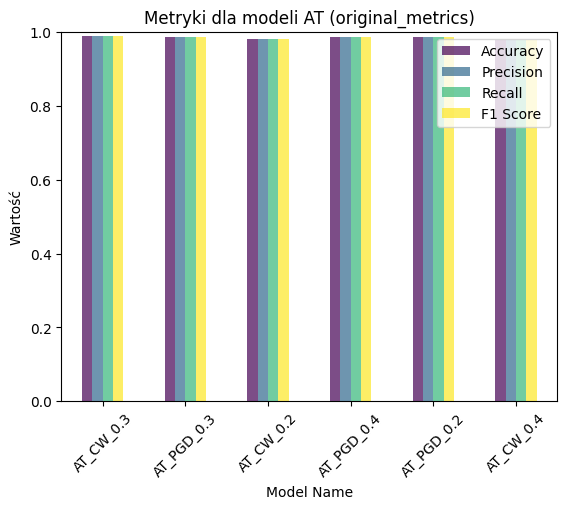

<Figure size 1200x600 with 0 Axes>

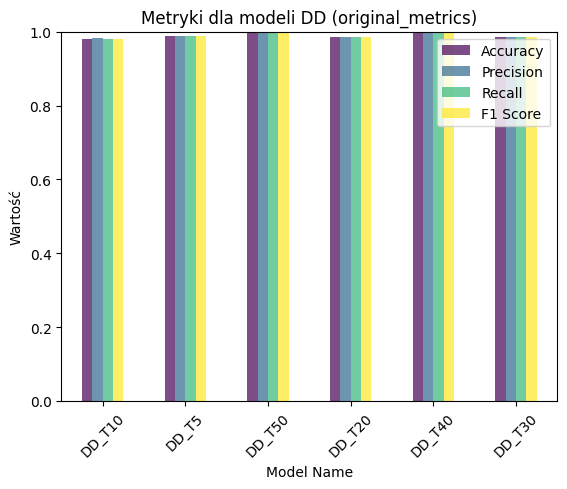

<Figure size 1200x600 with 0 Axes>

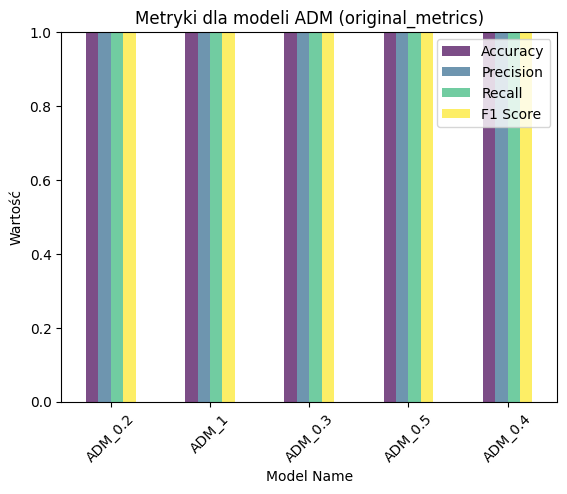

Tworzenie wykresów dla fgsm_adversarial_metrics:


<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

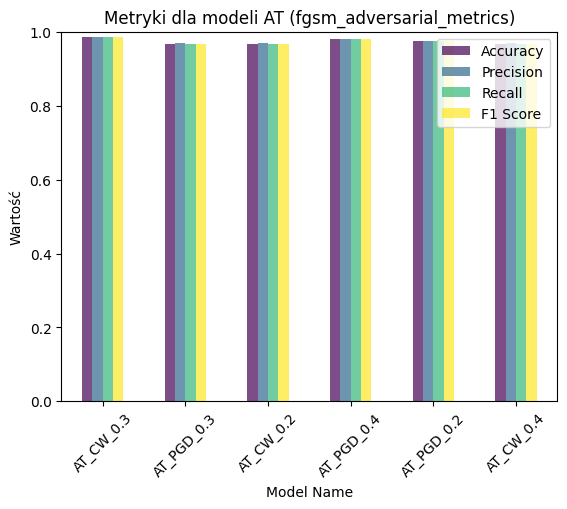

<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

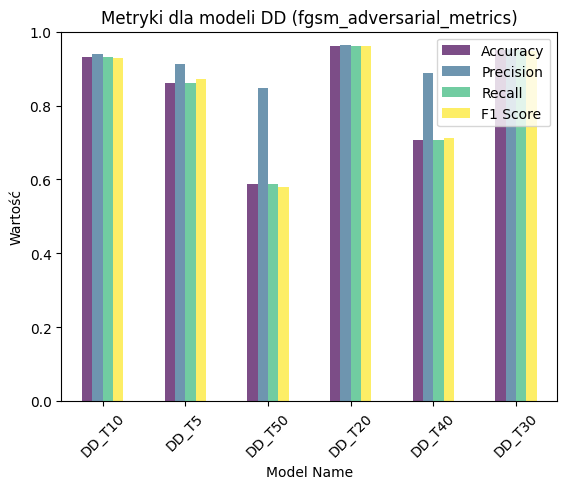

<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

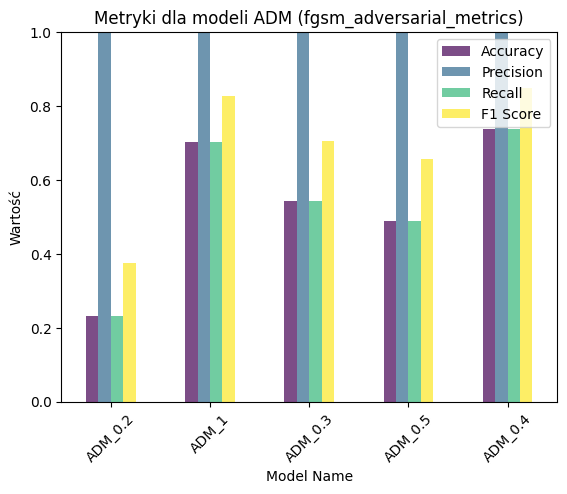

Tworzenie wykresów dla cw_adversarial_metrics:


<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

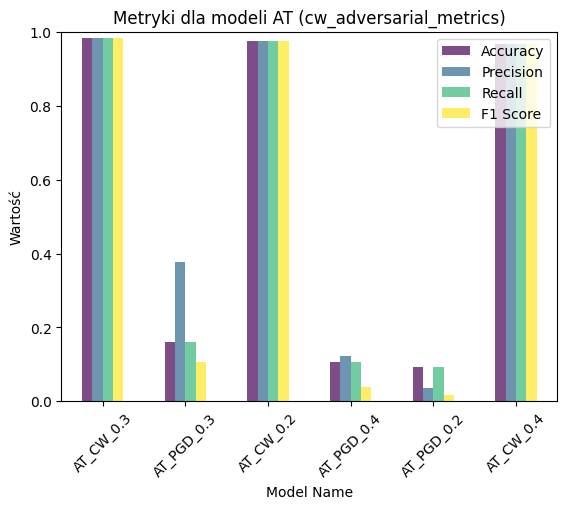

<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

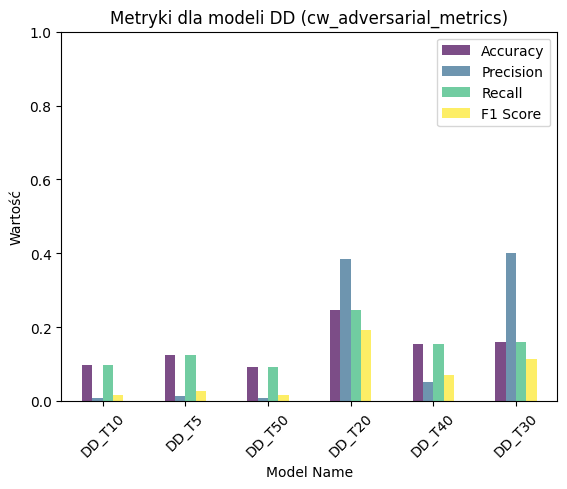

<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

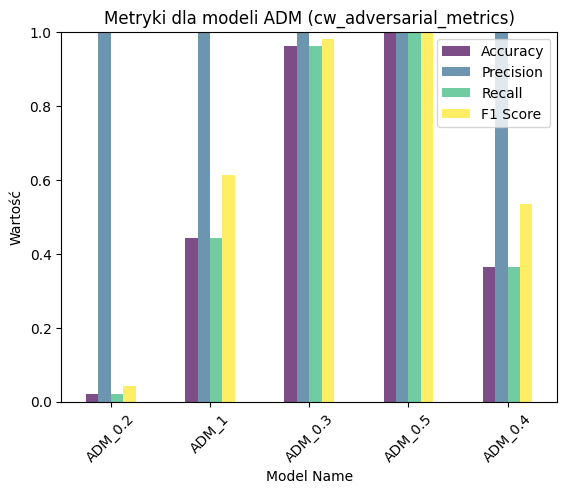

Tworzenie wykresów dla pgd_adversarial_metrics:


<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

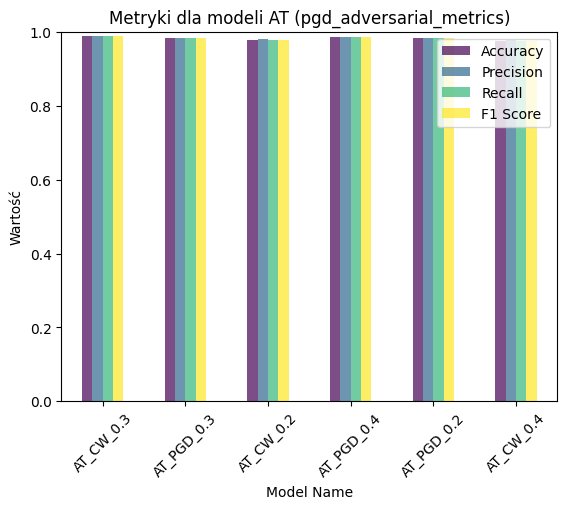

<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

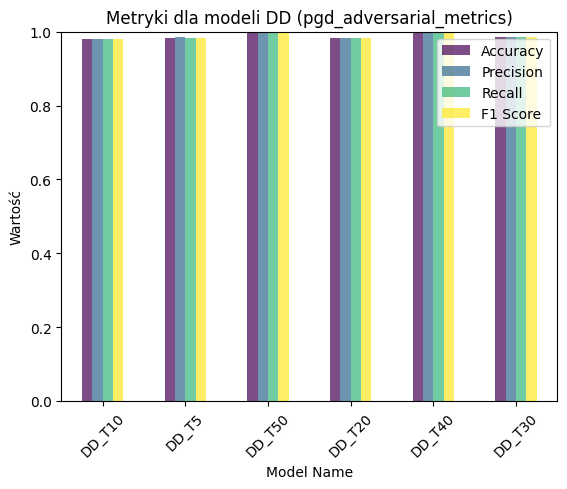

<ipython-input-26-6f5b7f8159da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli


<Figure size 1200x600 with 0 Axes>

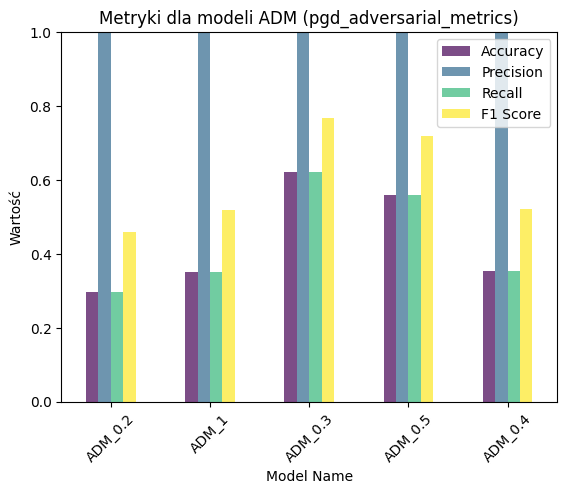

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Funkcja do rysowania wykresów dla wszystkich wystąpień
def rysuj_wszystkie_wykresy(dane, tytul, group_by="Model Name"):
    plt.figure(figsize=(12, 6))  # Zwiększamy szerokość wykresu
    dane = dane[['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]

    # Skracanie nazw modeli
    def skroc_nazwe(nazwa):
        if nazwa.startswith('AD_model_'):
            nazwa = nazwa.replace('AD_model_', 'AT_')
        elif nazwa.startswith('DD_model_'):
            nazwa = nazwa.replace('DD_model_', 'DD_')
        elif nazwa.startswith('ADM_model_extended_split_'):
            nazwa = nazwa.replace('ADM_model_extended_split_', 'ADM_')

        nazwa = nazwa.replace('.h5','')

        return nazwa  # Jeśli nie pasuje, zostawiamy bez zmian

    dane['Model Name'] = dane['Model Name'].apply(skroc_nazwe)  # Skracamy nazwy modeli

    dane = dane.set_index(group_by)  # Ustawiamy 'Model Name' jako indeks
    dane.plot(kind='bar', alpha=0.7, colormap='viridis')
    plt.title(tytul)
    plt.ylabel('Wartość')
    plt.ylim(0, 1)  # Zakładamy, że metryki są w zakresie [0, 1]
    plt.xticks(rotation=45, fontsize=10)  # Zmniejszamy czcionkę podpisów
    plt.legend(loc='upper right')
    plt.show()

# Tworzenie wykresów dla każdej ramki danych
for dataset_name, df in datasets.items():
    # Filtracja danych
    df_dd = df[df['Model Name'].str.startswith('DD')]
    df_adm = df[df['Model Name'].str.startswith('ADM')]
    df_ad = df[df['Model Name'].str.startswith('AD') & ~df['Model Name'].str.startswith('ADM')]  # Wykluczamy ADM

    # Rysowanie wykresów
    print(f"Tworzenie wykresów dla {dataset_name}:")
    rysuj_wszystkie_wykresy(df_ad, f'Metryki dla modeli AT ({dataset_name})')
    rysuj_wszystkie_wykresy(df_dd, f'Metryki dla modeli DD ({dataset_name})')
    rysuj_wszystkie_wykresy(df_adm, f'Metryki dla modeli ADM ({dataset_name})')


In [ ]:
datasets['cw_adversarial_metrics']

,Model Name,Attack Type,Norm,c,Accuracy,Precision,Recall,F1 Score
0,DD_model_T10.h5,CW,L2,[0.3],0.097,0.009409,0.097,0.017154
1,AD_model_CW_0.3.h5,CW,L2,[0.3],0.984,0.984539,0.984,0.984005
2,AD_model_PGD_0.3.h5,CW,L2,[0.3],0.161,0.377925,0.161,0.105707
3,DD_model_T5.h5,CW,L2,[0.3],0.124,0.015376,0.124,0.027359
4,AD_model_CW_0.2.h5,CW,L2,[0.3],0.975,0.975607,0.975,0.975028
5,AD_model_PGD_0.4.h5,CW,L2,[0.3],0.106,0.124032,0.106,0.039589
6,DD_model_T50.h5,CW,L2,[0.3],0.093,0.008649,0.093,0.015826
7,AD_model_PGD_0.2.h5,CW,L2,[0.3],0.094,0.035434,0.094,0.017812
8,DD_model_T20.h5,CW,L2,[0.3],0.246,0.385319,0.246,0.192836
9,DD_model_T40.h5,CW,L2,[0.3],0.155,0.052026,0.155,0.069916
